In [8]:
import cv2 as cv
import numpy as np
import pandas as pd
from datetime import datetime
import imutils
from matplotlib import pyplot as plt 

%matplotlib inline

In [22]:
TITLE_FONT_SIZE=20
FIG_SIZE=(12,12)
BLUR_KERNEL=(3,3)

def describe_data(numpy_array):
    df=pd.DataFrame({"a": numpy_array.flatten()})
    print(df.describe())

def plot_my_image(img,
                  plot_gray=False,
                  is_gray=False,
                 title=''):
    if is_gray==True:
        pass
    elif is_gray==False:
        img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig = plt.figure(figsize = FIG_SIZE) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    
    today=datetime.now()
    today.isoformat()
    ax.set_title(title+' '+today.isoformat(),fontsize = TITLE_FONT_SIZE)
    if plot_gray==True: 
        ax.imshow(img, interpolation='none',cmap='gray')
    elif plot_gray==False:
        ax.imshow(img, interpolation='none')
    plt.show()
    
def crop_background_with_mask(img,
                              mask):
    # load background (could be an image too)
    bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk, same size and type of image
    #bk = cv.rectangle(bk, (0, 0), (int(img.shape[1] / 2), int(img.shape[0] / 2)), 0, -1)  # rectangles
    #bk = cv.rectangle(bk, (int(img.shape[1] / 2), int(img.shape[0] / 2)), (img.shape[1], img.shape[0]), 0, -1)

    # get masked foreground
    fg_masked = cv.bitwise_and(img,
                               img,
                               mask=mask)
    # get masked background, mask must be inverted 
    mask = cv.bitwise_not(mask)
    bk_masked = cv.bitwise_and(bk, 
                               bk,
                               mask=mask)
    # combine masked foreground and masked background 
    final = cv.bitwise_or(fg_masked, 
                          bk_masked)
    mask = cv.bitwise_not(mask)  # revert mask to original    
    return final

def rotate_image(img,angle):
    
    rotated = imutils.rotate(img,
                             angle)
    return rotated

def resize_image(img,scale):
    
    #scale_percent = 50 # percent of original size
    width = int(img.shape[1] * scale / 100)
    height = int(img.shape[0] * scale / 100)
    dim = (width, height) 
    
    # resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return resized

def rotate_image_2(image,
                   angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    scale=1.0
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv.getRotationMatrix2D((cX, cY), -angle, scale)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv.warpAffine(image, M, (nW, nH))

def remove_background(img_original,
                      plot_images=True,
                      mythreshold=220,
                      myminLineLength=500,
                      mymaxLineGap=100,
                      mythickness=300,
                      is_gray=True,
                      blurthat=True,
                      blur_kernel=BLUR_KERNEL,
                      area_min=200,
                     ):
    if is_gray==True:
        red_channel=img_original
    elif is_gray==False:
        red_channel = img_original[:,:,2]
        gray = cv.cvtColor(img_original, cv.COLOR_BGR2GRAY)
        
    if blurthat==True:
        blurred =cv.blur(red_channel,ksize=blur_kernel)
    elif blurthat==False:
        blurred=red_channel
        
    if plot_images==True: 
        plot_my_image(blurred,False,False,title='blurred')
        
    (mu, sigma) = cv.meanStdDev(red_channel)
    edges = cv.Canny(image=blurred, 
                     threshold1=int(mu - sigma),
                     threshold2=int(mu + sigma))
    
    if plot_images==True: 
        plot_my_image(edges,False,title='edges')
        
    edges_without_dots=remove_white_small_dots(edges,area_min=area_min)    
    
    if plot_images==True: 
        plot_my_image(edges_without_dots,False,title='edges 2')
    
    lines = cv.HoughLinesP(edges_without_dots,
                            rho=1, 
                            theta=np.pi / 180,
                            threshold=mythreshold,#220
                            minLineLength=myminLineLength,#500
                            maxLineGap=mymaxLineGap #100
                            )
    
    print(f'Total lines: {len(lines)}')
    baseline=np.zeros(red_channel.shape)
    temp_img=img_original
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(baseline, 
                (x1, y1), 
                (x2, y2), 
                color=255, 
                thickness=mythickness)

    baseline=np.uint8(baseline)
    
    if plot_images==True: 
        plot_my_image(baseline,False,title='baseline')
    
    return blurred,edges,edges_without_dots,baseline

def normalize_image(img):
    
    red_channel = img_original[:,:,2]
    normalized=cv.equalizeHist(red_channel)
    return normalized


def remove_white_small_dots(img,area_min=100):
    # Taken from https://stackoverflow.com/a/57285053/10491422
    # convert to binary by thresholding
    ret, binary_map = cv.threshold(img,127,255,0)

    # do connected components processing
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_map,
                                        None, 
                                        None, 
                                        None, 
                                        8, 
                                        cv.CV_32S)

    #get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv.CC_STAT_AREA]

    result = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if areas[i] >= area_min:   #keep
            result[labels == i + 1] = 255
            
    return result

In [26]:
!wget https://imgur.com/b1e958X.png -O image.png

--2021-06-14 16:09:52--  https://imgur.com/b1e958X.png
Resolving imgur.com (imgur.com)... 151.101.20.193
Connecting to imgur.com (imgur.com)|151.101.20.193|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://i.imgur.com/b1e958X.png [following]
--2021-06-14 16:09:52--  https://i.imgur.com/b1e958X.png
Resolving i.imgur.com (i.imgur.com)... 151.101.4.193
Connecting to i.imgur.com (i.imgur.com)|151.101.4.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313989 (3.2M) [image/jpeg]
Saving to: ‘image.png’

image.png           100%[===================>]   3.16M   770KB/s    in 4.4s    

2021-06-14 16:09:58 (728 KB/s) - ‘image.png’ saved [3313989/3313989]



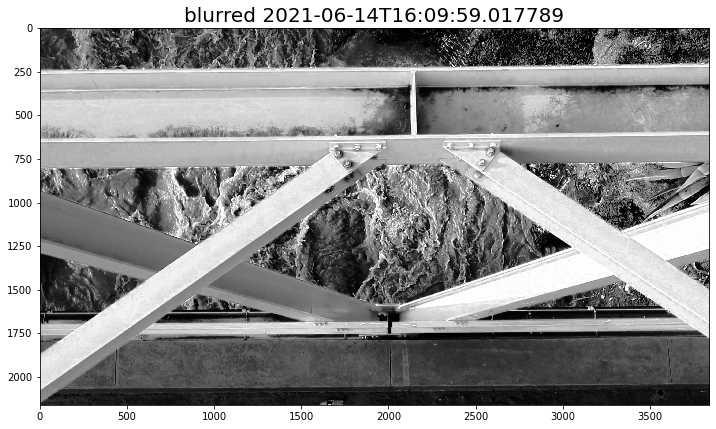

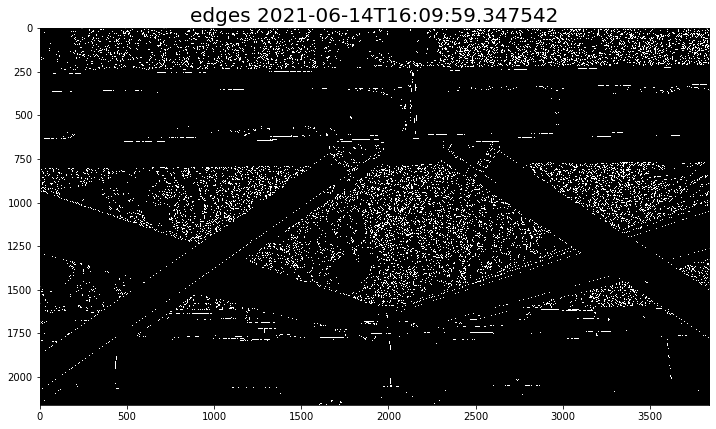

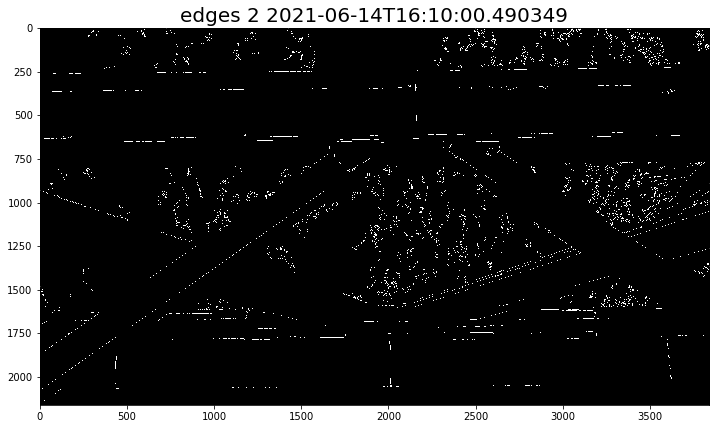

Total lines: 100


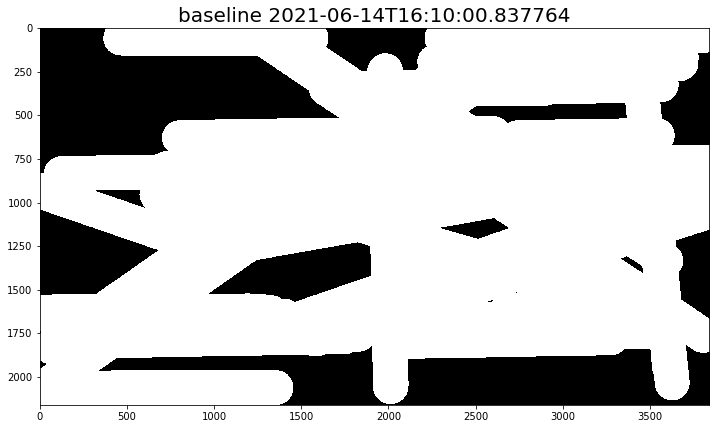

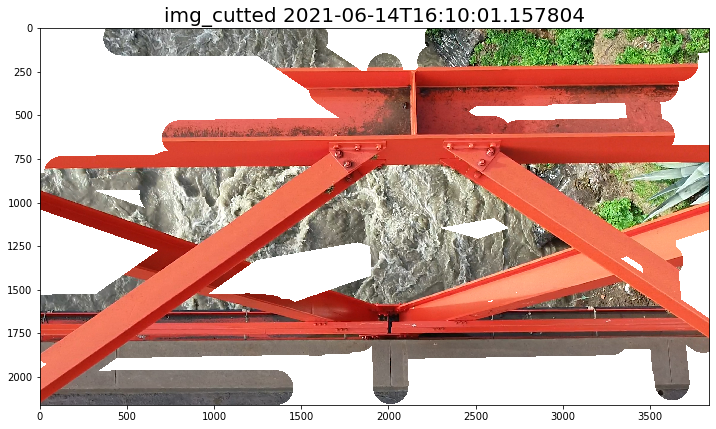

In [27]:
img_original = cv.imread("image.png", cv.IMREAD_UNCHANGED)

normalized=normalize_image(img_original)

blurred,edges,edges_without_dots,baseline_1=remove_background(normalized,
                            plot_images=True,
                            mythreshold=150,
                            myminLineLength=800,
                            mymaxLineGap=500,
                            mythickness=200,
                            blur_kernel=(3,3),
                            area_min=200,
                            )

img_cutted=crop_background_with_mask(img_original,baseline_1)
plot_my_image(img_cutted,False,title='img_cutted')

In [28]:
cv.imwrite('cutted.png',img_cutted)

True

In [29]:
img_cutted_resized=resize_image(img_cutted,30)
cv.imwrite('cutted_resized.png',img_cutted_resized)

True

# 2 - simply

In [123]:
!wget https://imgur.com/Y3wBwPO.png -O image.png

--2021-06-14 19:35:26--  https://imgur.com/Y3wBwPO.png
Resolving imgur.com (imgur.com)... 151.101.20.193
Connecting to imgur.com (imgur.com)|151.101.20.193|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://i.imgur.com/Y3wBwPO.png [following]
--2021-06-14 19:35:26--  https://i.imgur.com/Y3wBwPO.png
Resolving i.imgur.com (i.imgur.com)... 151.101.204.193
Connecting to i.imgur.com (i.imgur.com)|151.101.204.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3394228 (3.2M) [image/jpeg]
Saving to: ‘image.png’

image.png           100%[===================>]   3.24M   822KB/s    in 4.5s    

2021-06-14 19:35:32 (736 KB/s) - ‘image.png’ saved [3394228/3394228]



(2160, 3840, 3)


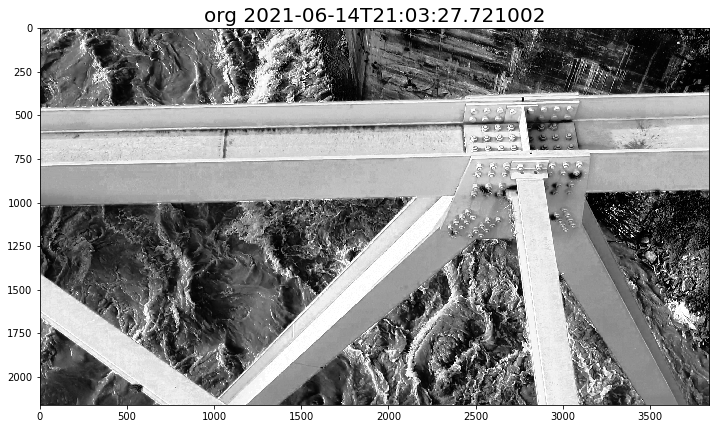

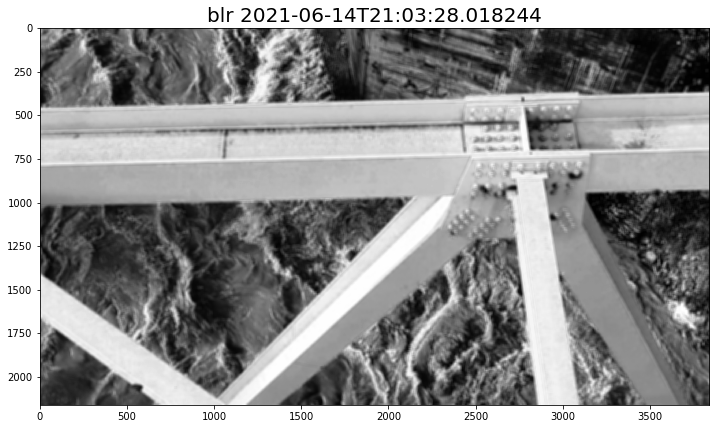

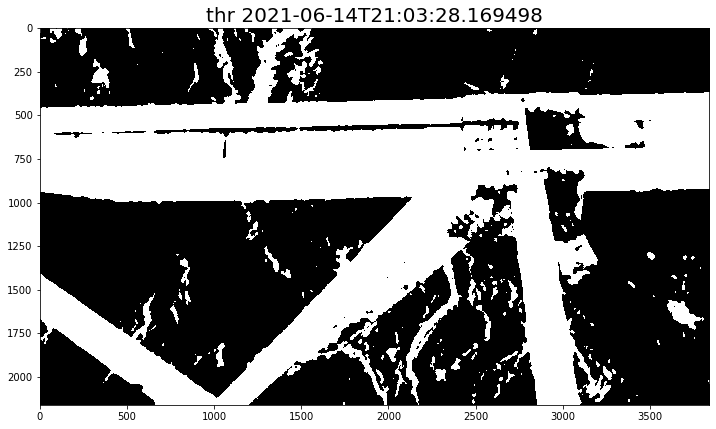

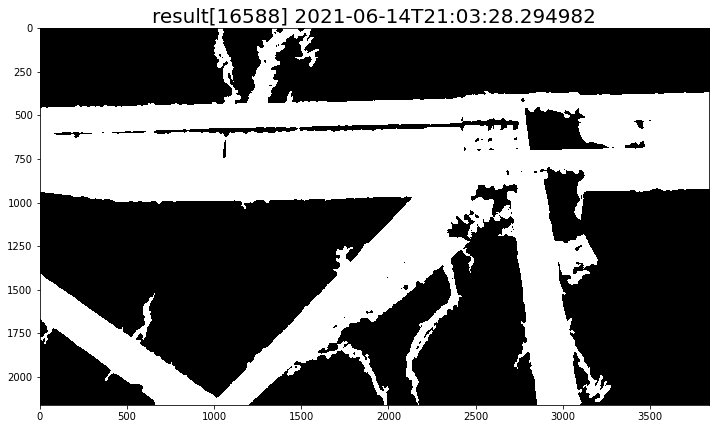

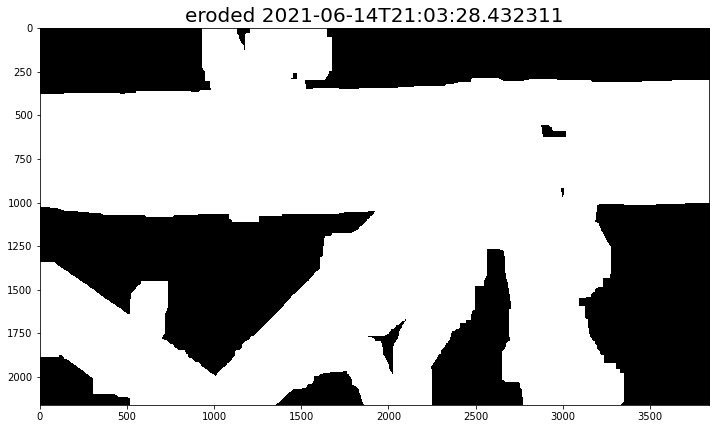

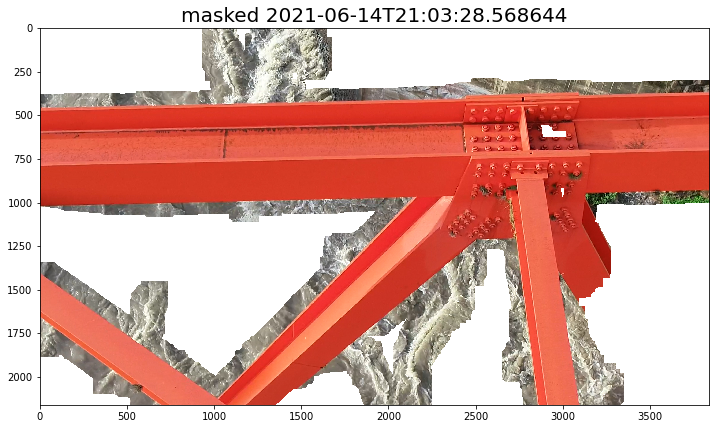

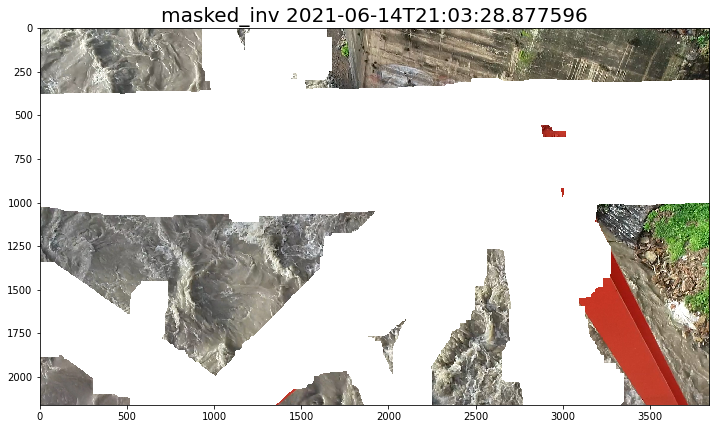

In [137]:
def remove_background_2(img_original,plot_images=False):

    BLUR_KERNEL=(int(max(img_original.shape)/200),int(max(img_original.shape)/200))

    # 1
    normalized=normalize_image(img_original)
    if plot_images: plot_my_image(normalized,False,False,title='org')

    # 2
    blurred =cv.blur(normalized,ksize=BLUR_KERNEL)
    if plot_images: plot_my_image(blurred,True,True,title='blr')

    # 3
    res,thr=cv.threshold(blurred,150,255,cv.THRESH_BINARY)
    if plot_images: plot_my_image(thr,True,True,title='thr')

    # 4
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(thr, 
                                                                        None, 
                                                                        None, 
                                                                        None, 
                                                                        8, 
                                                                        cv.CV_32S)

    areas = stats[1:,cv.CC_STAT_AREA]
    result = np.zeros((labels.shape), np.uint8)
    max_area=int(img_original.shape[0]*img_original.shape[1]/500)

    for i in range(0, nlabels - 1):
        if areas[i] >= max_area:   #keep
            result[labels == i + 1] = 255

    if plot_images: plot_my_image(result,True,True,title=f'result[{max_area}]')

    # 5 erode
    kernel = np.ones((30, 30), np.uint8)
    eroded=cv.dilate(result,kernel,iterations=5)
    if plot_images: plot_my_image(eroded,True,True,title='eroded')

    # 6 mask
    masked=crop_background_with_mask(img_original,
                                  eroded)
    if plot_images: plot_my_image(masked,False,False,title='masked')

    # 7 detector
    #img_cutted_resized=resize_image(masked,30)
    #cv.imwrite('processed.png',img_cutted_resized)
    
    # 8 mask inverted
    eroded_inv=cv.bitwise_not(eroded)
    masked_inv=crop_background_with_mask(img_original,
                                  eroded_inv)
    if plot_images: plot_my_image(masked_inv,False,False,title='masked_inv')
    
    return masked, masked_inv, eroded, eroded_inv
    
img_original = cv.imread("image.png", cv.IMREAD_UNCHANGED)
print(img_original.shape)    
masked, masked_inv, eroded, eroded_inv=remove_background_2(img_original,
                    plot_images=True)

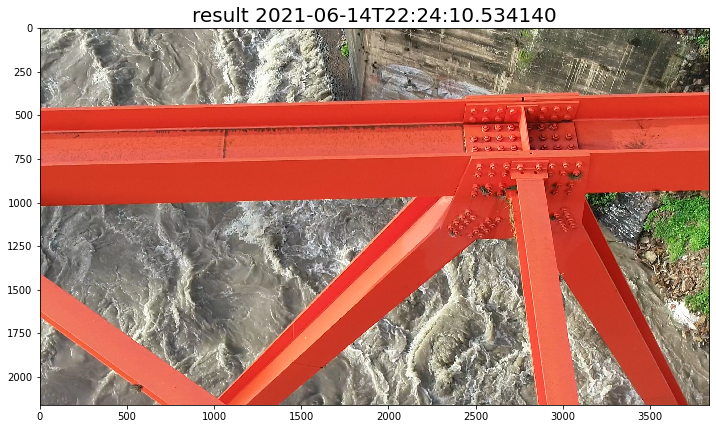

In [151]:
#result=cv.addWeighted(masked,-1, masked_inv, -1.0, 0.0)
result=cv.bitwise_and(masked,masked_inv)
plot_my_image(result,False,False,title='result')